# Exercise 4, Problem 2: Robot localization using particle filtering

In the lecture we have learned particle filtering, which can be interpreted as a Monte Carlo method for Hidden Markov Models. In this exercise, we learn how to use this method to track a moving robot's position over time. In this setting, we have access to the steering and velocity control inputs. We also have sensors that measure the distances to visible landmarks. The basic principle of particle filtering is then that the population of particles tracks the high-likelihood regions of the robot's position.

Your tasks is to complete the missing code. Make sure that all the functions follow the provided interfaces of the functions, i.e. the output of the function exactly matches the description in the docstring.
Adding or modifying code outside of the following comment blocks is not required:

```
##########################################################
# YOUR CODE HERE
.....
##########################################################
```

After you fill in all the missing code, restart the kernel and re-run all the cells in the notebook. You are **NOT** allowed to using additional `import`  statements.


In [1]:
import copy
import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches

from scipy import stats

# uncomment for multiple output in a cell
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

## Initialize particles
Since we don't have detailed information about the robot's starting position,
particles are initialized by uniformly sampling in the 2D space defined by the width and height of the map.

In [2]:
def uniform_particles_construction(width, height, N) -> np.ndarray:
    """Sample particles in 2D space with no landmarks randomly.

    Args:
        width, height: float, width (x) and height (y) of the area in which the robot moves
        N: int, number of particles
    Return:
        particles: numpy (np) array with particles centered around the origin with dimension particles.size = [N,2] 
    """
    np.random.seed(200)
    particles = np.random.uniform([0,0], [width, height], size=(N, 2))
    return particles

Here we show a example map in which the robot moves:

<img src="./data/PF_data/img/Map_Rejection_Sampling.png" alt="Encoder" style="width: 400px;">


## Task 2: Reject invalid particles
The map above contains landmarks shown as blue circles.
In this case, not all previous sampled particles are valid since these particles can not located inside the landmarks.
In this task you need to find the valid particles, namely, only those particles whose distance to each landmarks'
center is larger or equal to the landmarks' corresponding radius is considered as valid.

In [3]:
def find_valid_particles(particles, centers, radii):
    """Given randomly sampled particles, as well as centers and radii of landmarks, decide which particles are valid.
    
    Args:
        particles: the particles we get through random generation in 2D space
        centers: coordinate for each centers of landmarks
        radii: the radius of cicular landmarks 
    Return:
        valid_particles: the particles that locate outside the circular landmarks
    """
    valid_particles = []

    ###################################################################
    # YOUR CODE HERE
    for count, particle_coord in enumerate(particles):
        if (particle_coord[0] < 0) or (particle_coord[0] > 800) or (particle_coord[1] < 0) or (particle_coord[1] > 600):
            continue
        else:
            dis = np.linalg.norm(particle_coord-centers, axis=1, keepdims=True)
            if np.all(dis <= radii):
                continue
            else:
                valid_particles.append(particles[count])
    ###################################################################
    return np.asarray(valid_particles)

## Motion model
Next, the model for propagating the particles' positions needs to be defined.
Since we have access to the measured velocity and angle of the robot's current state,
we can incorporate this information into the prediction.
Furthermore, we add an uncertainty `std` (standard deviation) to account for the uncertain behavior in the next time step.

In [4]:
def propagate_particle_pos(particles, v, std):
    """Predict the position at the next time step for each particle given current angles and velocities.
    
    Args:
        particles: the particles we get after rejecting the ones that are not valid
        v： array with current measurements [angle, velocity]
        std: control the uncertainty of the prediction
    """
    N = len(particles)
    dt = 0.4
    # add some noise to the distance, the level is controlled by std
    delta_dist = (v[1] * dt)
    mean = (0, 0)

    # covariance for tangential and orthogonal uncertainty of the motion
    cov = [[std**2, 0], [0, (0.15*std)**2]]
    x = np.random.multivariate_normal(mean, cov, N)

    # update the positions of all particles
    particles[:, 0] += np.cos(v[0]) * (delta_dist + x[:,0]) - np.sin(v[0]) * x[:,1]
    particles[:, 1] += np.sin(v[0]) * (delta_dist + x[:,0]) + np.cos(v[0]) * x[:,1]


## Task 3: Update the weights of each particle
Update the weights of the particles based on the measured distances to the landmarks.
The weight denotes how well the sensor model can explain the deviation between the actual measurements and the distances to the landmarks taken from the estimated position.
The weights are normalized in order to obtain a probability distribution.
Those particles that are closer to the actual position of the robot will generally have a higher weight than those far away from the robot.

In this task, we use a normal probability distribution for the sensor model.

In [5]:
def weights_update(particles, weights, dist_r_l, centers, radii, std_sensor):
    """Given the noised distances between robot and the landmarks, update the weights of particles
        
    Args:
        particles: coordinate of particles
        weights: weights of particles
        dist_r_l: the current distance between robot and landmarks
        centers: coordinate for each center of the landmarks
        radii: the radius of the circular landmarks
        std_sensor: standard deviation of the normal distribution that represents the sensor model
    
    Return:
        weights: array with updated weights for each particle
        
    """
    weights.fill(1.)
    
    # in order to avoid round-off to zero, we add eps to each weight before multiplying it
    # e.g.: weights *= weight + eps
    eps = 1.e-15   
    
    for count, center in enumerate(centers):
        ###################################################################
        # YOUR CODE HERE
        # distance between the particles and each landmark
        dist_p_l = np.linalg.norm(particles-center, axis=1, keepdims=True) - radii[count]
        # weights_i = # to be computed
        weights_i = stats.norm.pdf(dist_p_l, dist_r_l[count], std_sensor)
        ###################################################################
        weights *=  weights_i + eps
        
    weights += eps
    # normalize weights
    weights /= sum(weights) + eps
    return weights

## Task 4: Resample Procedure
Resample the next set of particles from the previously propagated set of particles.
The probability of drawing a particle is based on its previously computed weight.
In principle, there are many ways to achieve this,
here you can refer to the procedure given in the paper [Resampling in Particle Filtering - Comparison](http://sait.cie.put.poznan.pl/38/SAIT_38_02.pdf)
to complete the systematic resampling method, which is summarized below where particles are denoted by
$ \mathbf{x}$ and weights are denoted by $\mathbf{q}$:

<img src="./data/PF_data/img/systematic_resample.png" alt="Encoder" style="width: 400px;"/>

This approach subdivides that the range of the weights $[0, 1)$ into N equally sized intervals,
and then draws samples within each interval $u^i \sim [\frac{i-1}{N}, \frac{i}{N})$.
Particles are selected for replication, such that $u^i \in [\sum_p^{j-1}q_p, \sum_p^{j}q_p)$.
This resampling algorithm has a complexity of *O(N)*, and is one of the more readily recommended, due to its simplicity and operation speed.

In [6]:
def resample_procedure(x, weights, u0=np.random.uniform()):
    """Perform the resampling procedure described above

    Args:
        x: particles from which to resample, shape = [N,2]
        weights: the weights of the particles
        u0: random number which is drawn only once

    Return:
        xx: the resampled particles
        idx: indices of the particles in the resampled array xx (same order as in xx)
    """
    N = len(weights)

    u = u0 / N
    xx = np.zeros_like(x)
    idx = np.zeros(N, dtype='int')
    sumQ = copy.copy(weights[0])
    ###################################################################
    # YOUR CODE HERE
    i, j = 0, 0
    for i in range(N):
        while sumQ < u and j < N - 1:
            j += 1
            sumQ += weights[j]
        xx[i, :] = x[j, :]
        idx[i] = j
        u += 1 / N
    ###################################################################
    return xx, idx

Using the indices of the resampled particles, we need to update the weights as well:

In [7]:
def update_resampled_weights(weights, idx):
    weights[:] = weights[idx]
    weights /= np.sum(weights)

## Load the data
Here we are provided with information about landmarks of the maps, and also the robot's trajectory as reference.
The velocity and distance data can be interpreted as the observed states in the HMM model.

In [8]:
landmark_centers = np.load('./data/PF_data/centers/example_centers.npy')
landmark_radii = np.load('./data/PF_data/radii/example_radii.npy')

angle_velocity = np.load('./data/PF_data/velocity/example_velocity.npy')
dist_r_l = np.load('./data/PF_data/distance/example_distance.npy')

# only for plotting - you should not touch this data in your implementation
input_sequence = np.load('./data/PF_data/trajectory/example_trajectory.npy')

Uncomment to see how a robot moves on a new map (doesn't influce results on Artemis).

In [9]:
# map_ID = 0  # choose between 0 and 1
# landmark_centers = np.load(f'./data/PF_data/centers/centers_{map_ID}.npy')
# landmark_radii = np.load(f'./data/PF_data/radii/radii_{map_ID}.npy')

# angle_velocity = np.load(f'./data/PF_data/velocity/velocity_{map_ID}.npy')
# dist_r_l = np.load(f'./data/PF_data/distance/distance_{map_ID}.npy')

# # only for plotting - you should not touch this data in your implementation
# input_sequence = np.load(f'./data/PF_data/trajectory/trajectory_{map_ID}.npy')

We add noise to the sensor data to simulate imperfect real-world measurements (doesn't influce results on Artemis).

In [10]:
distance_noise = 3.0
angle_noise = 0.05
velocity_noise = 20.0
dist_r_l += np.random.normal(0.0, distance_noise, size=dist_r_l.shape)
angle_velocity[:,0] += np.random.normal(0.0, angle_noise, size=angle_velocity[:,0].shape)
angle_velocity[:,1] += np.random.normal(0.0, velocity_noise, size=angle_velocity[:,1].shape)

## Set parameters
In this cell we set some predefined hyperparameters. The `uncertainty_motion_model` contains different levels for the uncertainty in the motion model.
`std_sensor` denotes the standard deviation of the distance measurements of the sensor.
In this setting, we have continuous transition and sensor models in contrast to discrete models as in the lecture.

In [11]:
width_max = 800
height_max = 600 
particle_num = 600

uncertainty_motion_model = {'no noise': 1.0, 'low noise': 7.0, 'high noise': 12.0}

std_sensor = 3.0

## Task 5: Main particle filtering algorithm
Finally, the implemented functions need to be put together in order to perform particle filtering.

In [12]:
def particle_filtering(width, height, N, centers, radii, velocity, distance, std_prediction, std_sensor):
    """ Main method for particle filtering. Returns the estimated trajectories of N particles.
        
    Args:
        width, height: decide moving regions of the robot
        N: number of particles
        centers: centers of landmarks
        radii: radii of landmarks
        distance: measured distances from the robot to the landmarks
        std_prediction: uncertainty used for prediction
        std_sensor: standard deviation of the sensor model
    Return:
        list of positions of all particles, shape = [len(distance), N, 2],
        list particle weights, shape = [len(distance), N]
        final weights of particles, shape = [len(distance), 1]
    
    """
    # First we initialize the particles and the particle weights
    random_particles = uniform_particles_construction(width, height, N)
    particle_pos = find_valid_particles(random_particles, centers, radii)
    particle_weights = np.ones((len(particle_pos),1))

    # Now we need to record the coordinates of moving particles
    particle_trajectories = [copy.copy(particle_pos)]
    estimate_positions = []

    for t in range(len(distance)-1):
        ###################################################################
        # YOUR CODE HERE
        propagate_particle_pos(particle_pos, velocity[t], std_prediction)
        weights_update(particle_pos, particle_weights, distance[t+1], centers, radii, std_sensor)
        particle_pos, random_index = resample_procedure(particle_pos, particle_weights)
        ###################################################################

        update_resampled_weights(particle_weights, random_index)
        particle_trajectories.append(copy.copy(particle_pos))
        estimate_positions.append(np.average(particle_pos, weights=particle_weights.flatten(), axis=0))

    particle_trajectory = np.asarray(particle_trajectories)
    estimate_positions = np.asarray(estimate_positions)
    
    return particle_trajectory, estimate_positions, particle_weights

In [13]:
# setting the seed ensures drawing consistent samples for each execution of the particle filter.
# This can be changed for testing purposes and doesn't influence the result on Artemis.
seed = 200

def concatenate_result(width, height, N, centers, radii, v, dist, noise, std_sensor):
    trajectory_all = []
    weight_all = []
    estimate_positions_all = []

    for noise_i in noise.values():
        np.random.seed(seed)
        trajectories, estimate_positions, weights = particle_filtering(width, height, N, centers, radii, v, dist, noise_i, std_sensor)
        trajectory_all.append(trajectories)
        estimate_positions_all.append(estimate_positions)
        weight_all.append(weights)

    return trajectory_all, weight_all, estimate_positions_all

In [14]:
trajectory_all, weight_all, estimate_positions = concatenate_result(width_max, height_max, particle_num, landmark_centers, landmark_radii, angle_velocity, dist_r_l, uncertainty_motion_model, std_sensor)

## Visualization
Now we visualize the ground truth movement of the robot to show how your particle filters works! What we need to achieve here is adding the moving of input sequence as well as particles onto that map.

In [15]:
plt.ion()
def location(time_step):
    fig,ax = plt.subplots(1, 3, figsize=(15, 5))
    vmax=np.max(np.concatenate([w.flatten() for w in weight_all]))

    for i in range(0, 3):
        ax_unpack = ax.ravel()
        ax_unpack[i].set_title(f"Transition model uncertainty: {list(uncertainty_motion_model.values())[i]}")
        ax_unpack[i].set_aspect('equal')
        ax_unpack[i].plot(estimate_positions[i][:time_step,0],
                          estimate_positions[i][:time_step,1], lw=1, c='b')

        ax_unpack[i].plot(input_sequence[:time_step + 1,0], input_sequence[:time_step + 1, 1], lw=1, c='r')
        ax_unpack[i].scatter(input_sequence[time_step, 0], input_sequence[time_step, 1], s=25, c='r', marker='x')
        order = np.argsort(weight_all[i].flatten()) # plot highly weighted points on top
        ax_unpack[i].scatter(trajectory_all[i][time_step, order, 0], trajectory_all[i][time_step, order, 1],s=2,
                             c=weight_all[i].flatten()[order], cmap=cm.winter, vmin=0.0, vmax=vmax)

        for count, value in enumerate(landmark_centers):
            circ = mpatches.Circle(value,landmark_radii[count], alpha=0.5)
            ax_unpack[i].add_patch(circ)
        ax_unpack[i].imshow(img)


### Legend
**red**: ground truth positions

**blue**: weighted average of the particle's positions

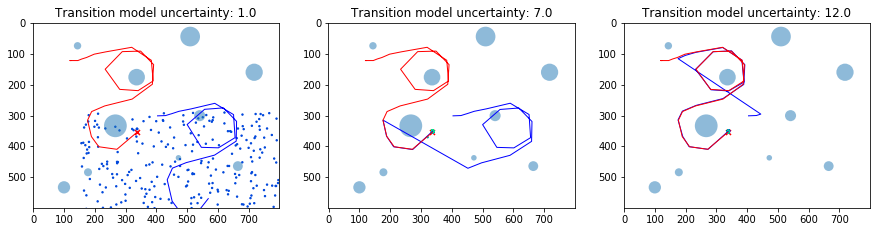

In [16]:
img = plt.imread('data/PF_data/img/Canvas.png')

iplot = ipywidgets.interactive(location, time_step=(0, len(trajectory_all[1])-2))
iplot

## Understanding the result
If your implementation is correct, the particles will eventually converge to the ground truth trajectory (red).
As you can see, the results strongly depend on the uncertainty in the transition model.
### Questions for yourself:
- Why does a model with larger uncertainties often outperform the model with the smallest uncertainty?
- How could this particle filter be improved? Also, try to play with the hyperparameters. 